In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import joblib

# Rechargez les données (assurez-vous d'avoir sauvegardé une version nettoyée, sinon refaites les étapes de renommage)
df = pd.read_csv('../data/raw/credit_card_default.csv', header=1)
df = df.rename(columns={'default payment next month': 'TARGET'})

In [2]:
X = df.drop('TARGET', axis=1)
y = df['TARGET']

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,    # 20% des données pour le test
    random_state=42,  # Pour que la séparation soit toujours la même
    stratify=y        # C'EST LE PARAMÈTRE LE PLUS IMPORTANT ICI !
)

In [4]:
# Colonnes catégorielles
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE']

# Colonnes numériques (on prend tout sauf les catégorielles et l'ID client)
numeric_features = [col for col in X.columns if col not in categorical_features + ['ID']]

# Les variables PAY_X sont ordinales, on les traitera comme numériques pour cette baseline
# On pourrait les traiter différemment dans un modèle plus avancé

In [5]:
# Pipeline pour les variables numériques
numeric_transformer = StandardScaler()

# Pipeline pour les variables catégorielles
categorical_transformer = OneHotEncoder(handle_unknown='ignore') # ignore les catégories non vues à l'entraînement

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Garde les autres colonnes (ID) intactes
)

In [7]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='saga',max_iter=500, random_state=42))
])

In [8]:
# Le pipeline applique le prétraitement et entraîne le modèle sur X_train, y_train
model_pipeline.fit(X_train, y_train)
print("Modèle de référence entraîné !")

Modèle de référence entraîné !


C:\Users\Ahmad\loan\venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [9]:
# Évaluation sur le set de test
accuracy = model_pipeline.score(X_test, y_test)
print(f"Accuracy du modèle de référence sur le set de test : {accuracy:.4f}")

Accuracy du modèle de référence sur le set de test : 0.7785


In [10]:
# Sauvegarder le pipeline dans un fichier
joblib.dump(model_pipeline, 'baseline_logistic_regression_pipeline.pkl')
print("Pipeline sauvegardé !")

Pipeline sauvegardé !


In [11]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [12]:
# Pipeline pour le Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Pipeline pour XGBoost
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

# Pipeline pour LightGBM
lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(random_state=42))
])

# N'oublions pas notre baseline
lr_pipeline = joblib.load('baseline_logistic_regression_pipeline.pkl')

In [13]:
from sklearn.model_selection import StratifiedKFold, cross_validate
import time

# On définit notre stratégie : 5 "plis" stratifiés
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [14]:
scoring_metrics = ['roc_auc', 'accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

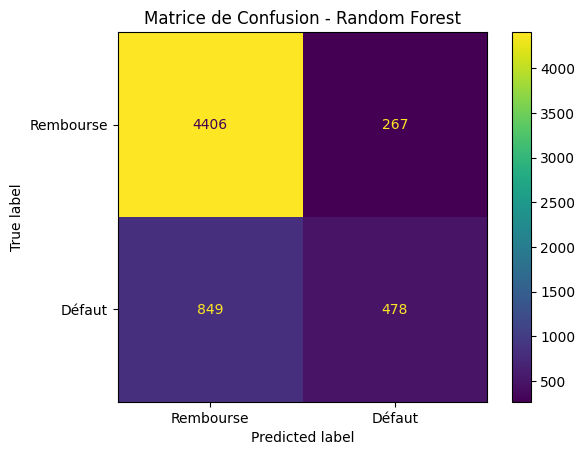

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
rf_pipeline.fit(X_train, y_train)
predictions = rf_pipeline.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, predictions, display_labels=['Rembourse', 'Défaut'])
plt.title('Matrice de Confusion - Random Forest')
plt.show()

In [17]:
# Dictionnaire de nos modèles
models = {
    "Régression Logistique": lr_pipeline,
    "Random Forest": rf_pipeline,
    "XGBoost": xgb_pipeline,
    "LightGBM": lgbm_pipeline
}

results = {}

print("Début de l'évaluation des modèles...")

for name, model in models.items():
    start_time = time.time()
    
    # Exécuter la validation croisée
    cv_results = cross_validate(model, X_train, y_train, cv=cv_strategy, scoring=scoring_metrics)
    
    end_time = time.time()
    
    # Stocker les résultats
    results[name] = {
        'ROC AUC (Moyenne CV)': cv_results['test_roc_auc'].mean(),
        'ROC AUC (Écart-type CV)': cv_results['test_roc_auc'].std(),
        'Recall (Moyenne CV)': cv_results['test_recall_macro'].mean(),
        'Precision (Moyenne CV)': cv_results['test_precision_macro'].mean(),
        'Temps d\'entraînement (s)': end_time - start_time
    }
    print(f"{name} évalué en {end_time - start_time:.2f} secondes.")

# Créer un DataFrame à partir des résultats
results_df = pd.DataFrame(results).T # .T pour transposer le tableau

# Afficher le tableau final
results_df

Début de l'évaluation des modèles...


C:\Users\Ahmad\loan\venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Ahmad\loan\venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Ahmad\loan\venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Ahmad\loan\venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Ahmad\loan\venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Régression Logistique évalué en 230.14 secondes.
Random Forest évalué en 77.41 secondes.


C:\Users\Ahmad\loan\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:41:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Ahmad\loan\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:41:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Ahmad\loan\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:41:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Ahmad\loan\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:41:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr

XGBoost évalué en 5.47 secondes.
[LightGBM] [Info] Number of positive: 4248, number of negative: 14952
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3529
[LightGBM] [Info] Number of data points in the train set: 19200, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221250 -> initscore=-1.258397
[LightGBM] [Info] Start training from score -1.258397


C:\Users\Ahmad\loan\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Ahmad\loan\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4247, number of negative: 14953
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3532
[LightGBM] [Info] Number of data points in the train set: 19200, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221198 -> initscore=-1.258699
[LightGBM] [Info] Start training from score -1.258699


C:\Users\Ahmad\loan\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Ahmad\loan\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4247, number of negative: 14953
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3532
[LightGBM] [Info] Number of data points in the train set: 19200, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221198 -> initscore=-1.258699
[LightGBM] [Info] Start training from score -1.258699


C:\Users\Ahmad\loan\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Ahmad\loan\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4247, number of negative: 14953
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3533
[LightGBM] [Info] Number of data points in the train set: 19200, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221198 -> initscore=-1.258699
[LightGBM] [Info] Start training from score -1.258699


C:\Users\Ahmad\loan\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Ahmad\loan\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4247, number of negative: 14953
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3529
[LightGBM] [Info] Number of data points in the train set: 19200, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221198 -> initscore=-1.258699
[LightGBM] [Info] Start training from score -1.258699
LightGBM évalué en 13.51 secondes.


C:\Users\Ahmad\loan\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Ahmad\loan\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,ROC AUC (Moyenne CV),ROC AUC (Écart-type CV),Recall (Moyenne CV),Precision (Moyenne CV),Temps d'entraînement (s)
Régression Logistique,0.523823,0.016042,0.504813,0.651204,230.139572
Random Forest,0.768989,0.004762,0.658193,0.750545,77.408360
XGBoost,0.763762,0.004602,0.655042,0.734012,5.473087
LightGBM,0.778708,0.004496,0.659170,0.754359,13.507857


LightGBM a le meilleur ROC AUC moyen (0,779) et le meilleur Recall (0,659). Le temps d'entraînement de 13s est bien 
meilleur que celui de RL(230s) et RF(77s) mais est-ce que ça vaut le coup comparé à XGBoost (5s) avec 
des performances quasiment similaires.
Au vu des résultats, le modèle XGBoost semble offrir le meilleur compromis entre une excellente performance-rappel
(ROC AUC de 0.764, Recall de 0,655) et un temps d'entraînement, je le sélectionne donc pour la prochaine étape.